In [1]:
import os
from PIL import Image
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
os.chdir(os.getcwd()+'\\train_images\\')

In [2]:
# don't run without train_images folder
images = os.listdir()
size_counts = defaultdict(int)
def is_jpg(filename):
    try:
        i=Image.open(filename)
        return i.format =='JPEG'
    except IOError:
        return False
for i in range(len(images)-1, len(images)):
    if not is_jpg(images[i]):
        continue
    im = Image.open(images[i])
    size_counts[im.size]+=1
size_counts = dict(size_counts)
print(len(images), "images of size:", im.size)

21397 images of size: (800, 600)


(800, 600)


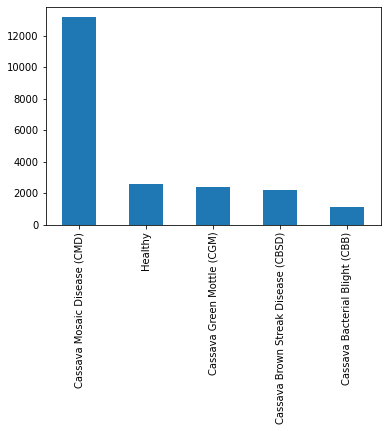

In [3]:
def numToLong(input):
    return {"0": "Cassava Bacterial Blight (CBB)", 
            "1": "Cassava Brown Streak Disease (CBSD)", 
            "2": "Cassava Green Mottle (CGM)", 
            "3": "Cassava Mosaic Disease (CMD)", 
            "4": "Healthy"}[str(input)]

df = pd.read_csv('../train.csv')
df['long_labels'] = df.label.map(lambda x: numToLong(x))
df.long_labels.value_counts().plot.bar()
print(im.size)